In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import BSpline
import torch

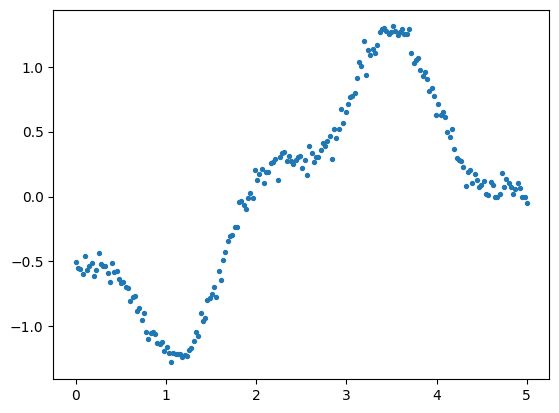

In [2]:
# Create mock training-data
n = 200
x_train = torch.linspace(0, 5, n).reshape((-1, 1))

y_train = x_train[:, 0] * 10 - x_train[:, 0]**2 * 1.7 + torch.sin(x_train[:, 0] * 4) * 2 + torch.randn(n) * 1

y_train = -torch.cos(x_train[:, 0] * 1.2 - 1) + torch.sin(x_train[:, 0] * 4) * 0.3 + torch.randn(n) * 0.05

plt.scatter(x_train[:, 0], y_train, s=8);

In [3]:
def term_to_quadratic_spline_terms(x, x_min, x_max, n_coefficients):
    # input shape [n_readings]
    # returns shape [n_readings, n_coefficients]
    
    n_knots = n_coefficients + 3
    d = (x_max - x_min) / (n_knots - 5)

    knots = torch.linspace(x_min - 2*d, x_max + 2*d, n_knots)
    
    x_spline = np.zeros((x.shape[0], n_coefficients))
    
    for i in range(n_coefficients):
        c = torch.zeros(n_coefficients)
        c[i] = 1
        spline = BSpline(knots, c, 2)
        x_spline[:, i] = spline(x)
        
    return x_spline

# Create spline terms

In [4]:
n_coefficients = 20

x_spline = torch.tensor(
    term_to_quadratic_spline_terms(x_train[:, 0], 0, 5, n_coefficients),
    dtype=torch.float32
)

print(x_train.shape)
print(x_spline.shape)

torch.Size([200, 1])
torch.Size([200, 20])


# Unconstrained spline

CPU times: user 1.11 s, sys: 395 ms, total: 1.51 s
Wall time: 1.52 s


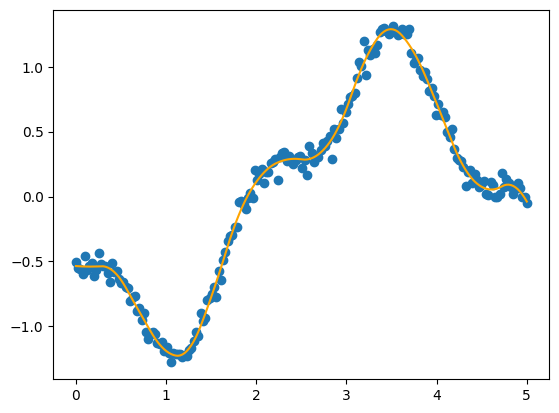

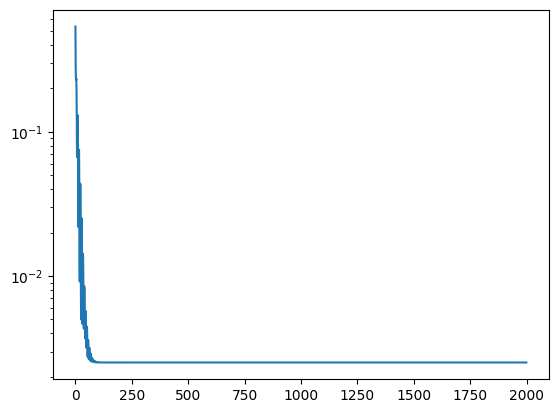

In [5]:
%%time

# Spline coefficients
w = torch.zeros(x_spline.shape[1], requires_grad=True, dtype=torch.float32)

# Define optimized and learning-rate schedule
start_lr = 1
end_lr = 0.001
n_epochs = 2000
r = (end_lr / start_lr) ** (1 / n_epochs)

optimizer = torch.optim.Adam([w], lr=start_lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=r)

losses = []

for i in range(n_epochs):
    y_pred = torch.matmul(x_spline, w)
    loss = torch.nn.functional.mse_loss(y_pred, y_train)
    
    # Log loss
    losses.append(loss.item())
    
    # Optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

# Plot sample data
plt.scatter(x_train, y_train)

# Plot fit
y_plot = (np.matmul(x_spline, w.detach().numpy()))
plt.plot(x_train, y_plot, c="orange")

# Plot losses
plt.figure()
plt.plot(losses)
plt.yscale("log")

# Smoothing spline

CPU times: user 830 ms, sys: 0 ns, total: 830 ms
Wall time: 827 ms


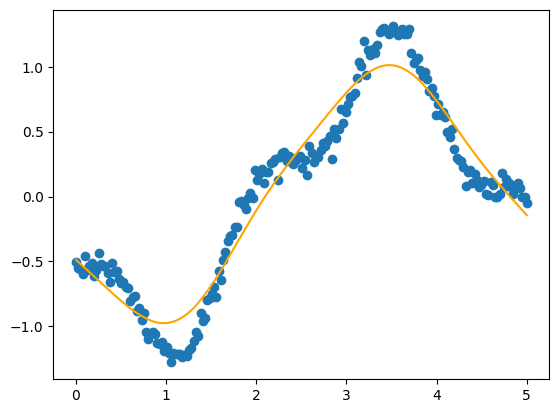

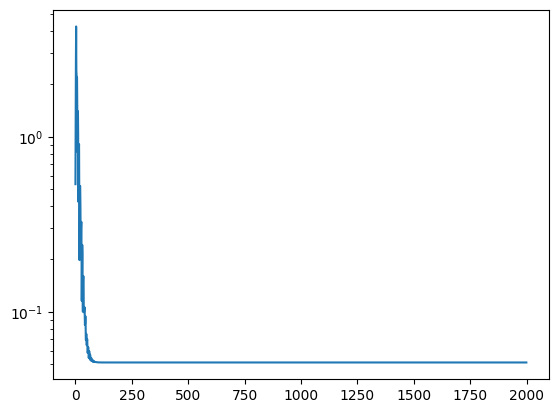

In [6]:
%%time

# Spline coefficients
w = torch.zeros(x_spline.shape[1], requires_grad=True, dtype=torch.float32)

# Define optimized and learning-rate schedule
start_lr = 1
end_lr = 0.001
n_epochs = 2000
r = (end_lr / start_lr) ** (1 / n_epochs)

optimizer = torch.optim.Adam([w], lr=start_lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=r)

losses = []

for i in range(n_epochs):
    y_pred = torch.matmul(x_spline, w)
    loss = torch.nn.functional.mse_loss(y_pred, y_train)
    
    # Penalize second derivative squared
    loss += 0.15 * (w.diff().diff() ** 2).sum()
    
    # Log loss
    losses.append(loss.item())
    
    # Optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

# Plot sample data
plt.scatter(x_train, y_train)

# Plot fit
y_plot = (np.matmul(x_spline, w.detach().numpy()))
plt.plot(x_train, y_plot, c="orange")

# Plot losses
plt.figure()
plt.plot(losses)
plt.yscale("log")

# Monotonically increasing spline

CPU times: user 814 ms, sys: 0 ns, total: 814 ms
Wall time: 811 ms


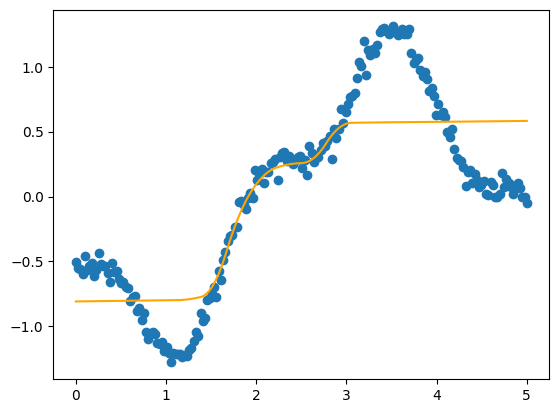

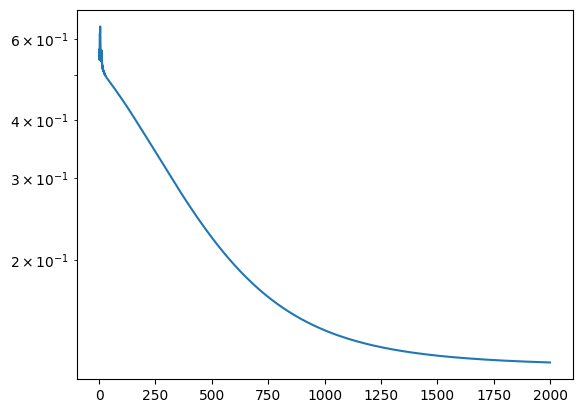

In [7]:
%%time

# Spline coefficients
w = torch.zeros(x_spline.shape[1], requires_grad=True, dtype=torch.float32)

# Define optimized and learning-rate schedule
start_lr = 0.01
end_lr = 0.001
n_epochs = 2000
r = (end_lr / start_lr) ** (1 / n_epochs)

optimizer = torch.optim.Adam([w], lr=start_lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=r)

losses = []

for i in range(n_epochs):
    y_pred = torch.matmul(x_spline, w)
    loss = torch.nn.functional.mse_loss(y_pred, y_train)
    
    # Penalize negative derivative
    loss += 5 * torch.nn.functional.softplus(-w.diff(), beta=2000).sum()
    
    # Log loss
    losses.append(loss.item())
    
    # Optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

# Plot sample data
plt.scatter(x_train, y_train)

# Plot fit
y_plot = (np.matmul(x_spline, w.detach().numpy()))
plt.plot(x_train, y_plot, c="orange")

# Plot losses
plt.figure()
plt.plot(losses)
plt.yscale("log")

# Convex increasing spline

CPU times: user 1.03 s, sys: 0 ns, total: 1.03 s
Wall time: 1.02 s


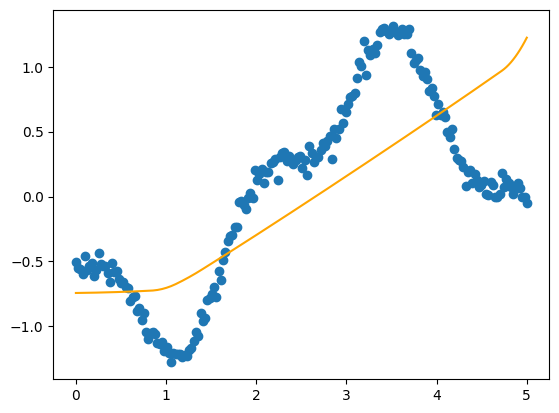

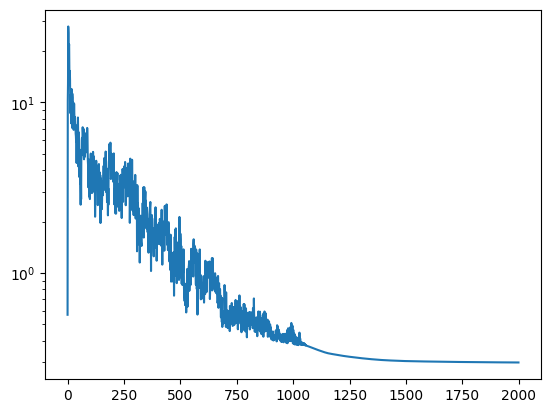

In [9]:
%%time

# Spline coefficients
w = torch.zeros(x_spline.shape[1], requires_grad=True, dtype=torch.float32)

# Define optimized and learning-rate schedule
start_lr = 0.5
end_lr = 0.001
n_epochs = 2000
r = (end_lr / start_lr) ** (1 / n_epochs)

optimizer = torch.optim.Adam([w], lr=start_lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=r)

losses = []

for i in range(n_epochs):
    y_pred = torch.matmul(x_spline, w)
    loss = torch.nn.functional.mse_loss(y_pred, y_train)
    
    # Penalize negative initial derivative
    loss += 5 * torch.nn.functional.softplus(-w.diff()[0], beta=2000).sum()
    
    # Penalize negative second derivative
    loss += 5 * torch.nn.functional.softplus(-w.diff().diff(), beta=2000).sum()
    
    # Log loss
    losses.append(loss.item())
    
    # Optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

# Plot sample data
plt.scatter(x_train, y_train)

# Plot fit
y_plot = (np.matmul(x_spline, w.detach().numpy()))
plt.plot(x_train, y_plot, c="orange")

# Plot losses
plt.figure()
plt.plot(losses)
plt.yscale("log")